<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/Getting_started_TensorFlow2/Validation_regularisation_callbacks/Regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install --no-cache-dir -qU pip wheel
pip install --no-cache-dir -qU numpy pandas matplotlib seaborn scikit-learn
pip install --no-cache-dir -qU tensorflow-gpu
pip check

In [2]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

import tensorflow as tf
tf.keras.utils.set_random_seed(42)

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

In [3]:
class PlotHistory():
    plt_nrows = 1
    plt_ncols = 2
    plt_figsize = (15, 5)
    
    def __init__(self, history, metrics=['loss']):
        super().__init__()
        self.history = history
        self.metrics = metrics
        
    @classmethod
    def _create_plot(cls):
        return plt.subplots(nrows=cls.plt_nrows,
            ncols=cls.plt_ncols, figsize=cls.plt_figsize)
    
    def plot(self):
        df_history = pd.DataFrame(self.history.history,
            index=self.history.epoch)
        fig, axes = self._create_plot()
        for ax, metric in zip(axes, self.metrics):
            sns.lineplot(ax=ax, data=df_history, 
                x=df_history.index+1, y=metric, label='train')
            try:
                sns.lineplot(ax=ax, data=df_history,
                    x=df_history.index+1, y=f'val_{metric}',
                    label='valid')
            except Exception:
                pass
            ax.legend(loc='best')
            ax.set_xlabel('epoch')
            ax.set_ylabel(f'{metric}')
            ax.set_title(f'{metric} vs. epoch')
        fig.tight_layout()
        plt.show()

# Validation, Regularisation and Callbacks

## Coding tutorials
#### [1. Validation sets](#coding_tutorial_1)
#### [2. Model regularisation](#coding_tutorial_2)
#### [3. Introduction to callbacks](#coding_tutorial_3)
#### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layes.Dense(128, activation='tanh'))
model.add(tf.keras.layers.Dense(2))

opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=opt, 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

history = model.fit(inputs, targets, validation_split=0.2)

print(history.history.keys()) # dict_keys(['loss', 'mape', 'val_loss', 'val_mape'])

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

model.fit(X_train, y_train, validation_data=(X_test, y_test))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

model.fit(X_train, y_train, validation_data=(X_val, y_val))

#### Load the data

In [4]:
# Load the diabetes dataset
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])
print('\n', diabetes_dataset.keys())

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [5]:
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [6]:
# Normalise the target data will make clearer training curves
targets = (targets - targets.mean(axis=0)) / targets.std()

In [7]:
# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [9]:
# Build the model
def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation="relu", 
            input_shape=(train_data.shape[1],)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1)])
    return model

model = get_model()

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               1408      
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 1)                

In [10]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

print(model.loss)
print(model.optimizer)

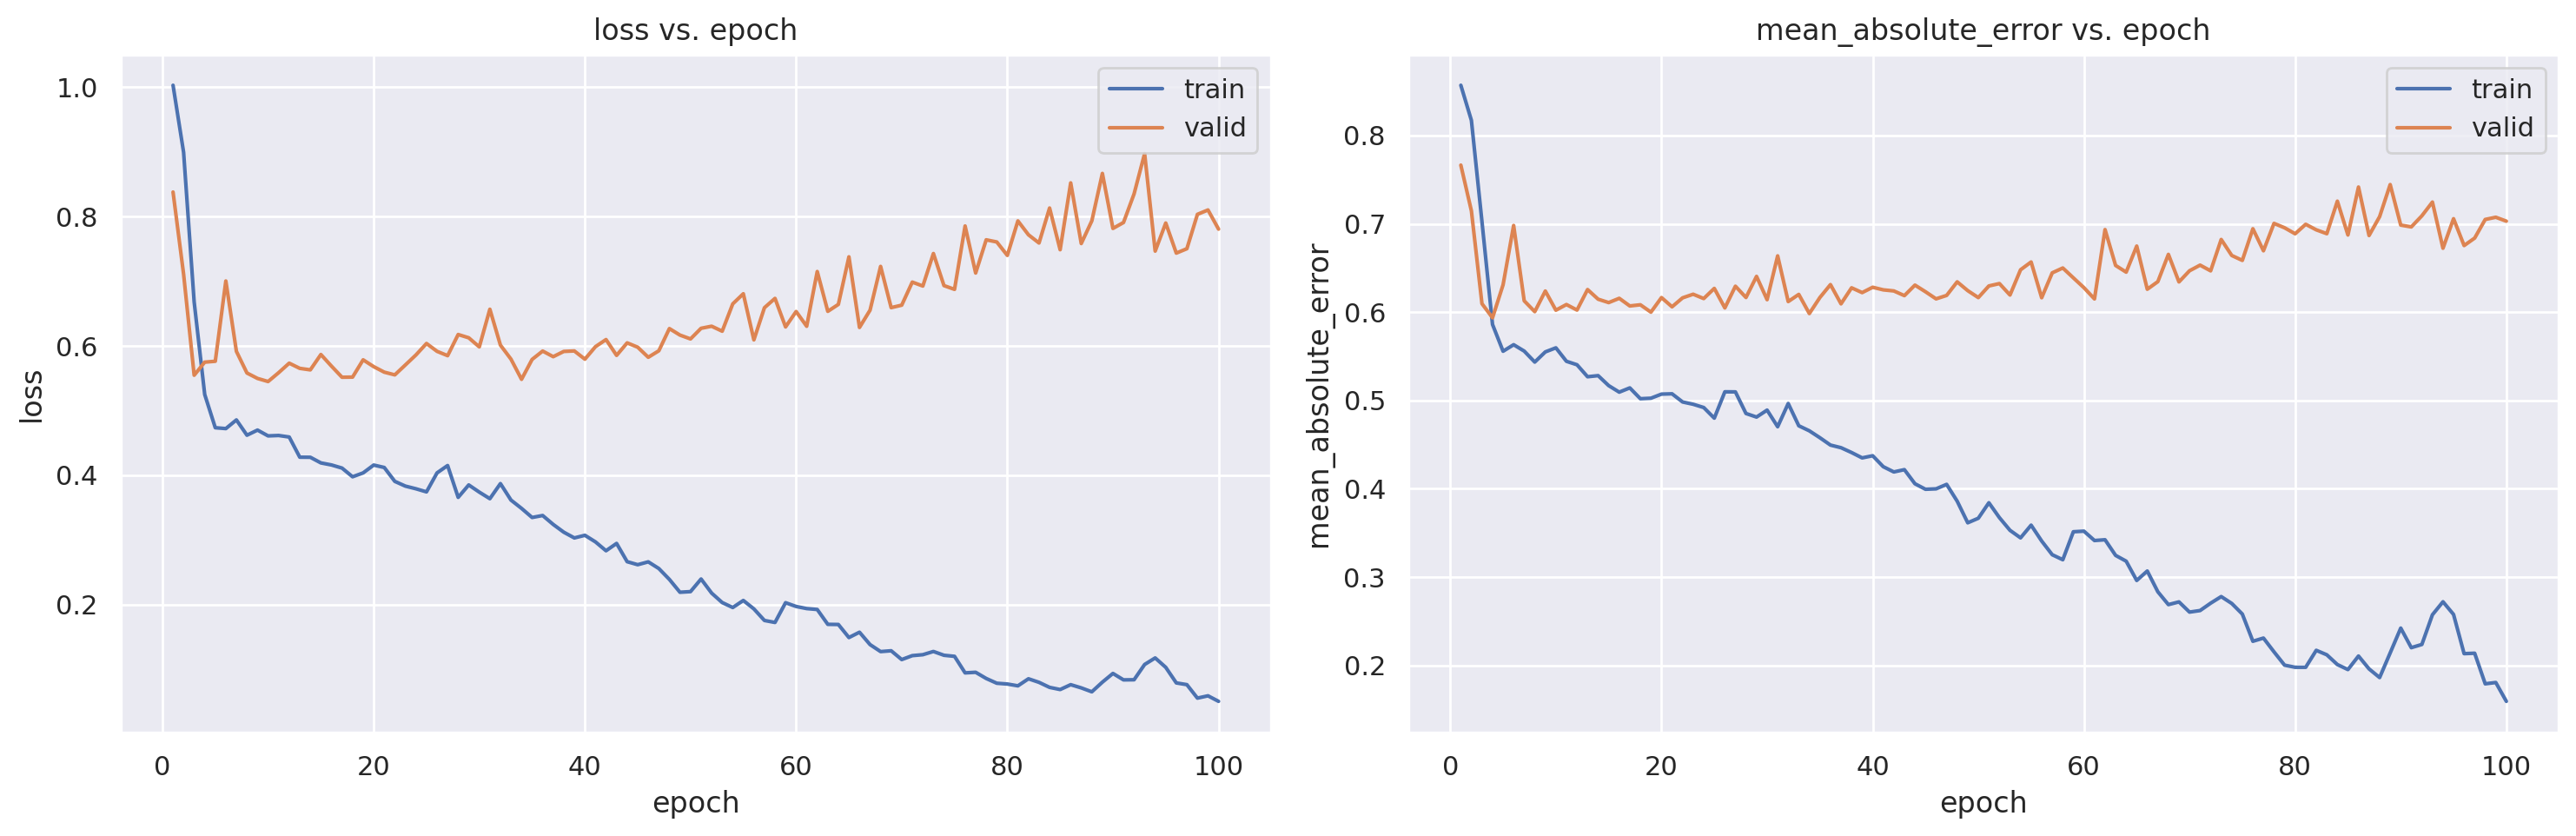

In [11]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100,
    validation_split=0.15, batch_size=64, verbose=0)

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error'])\
    .plot()

In [12]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=0)

[0.7211934328079224, 0.6083576679229736]

#### Plot the learning curves

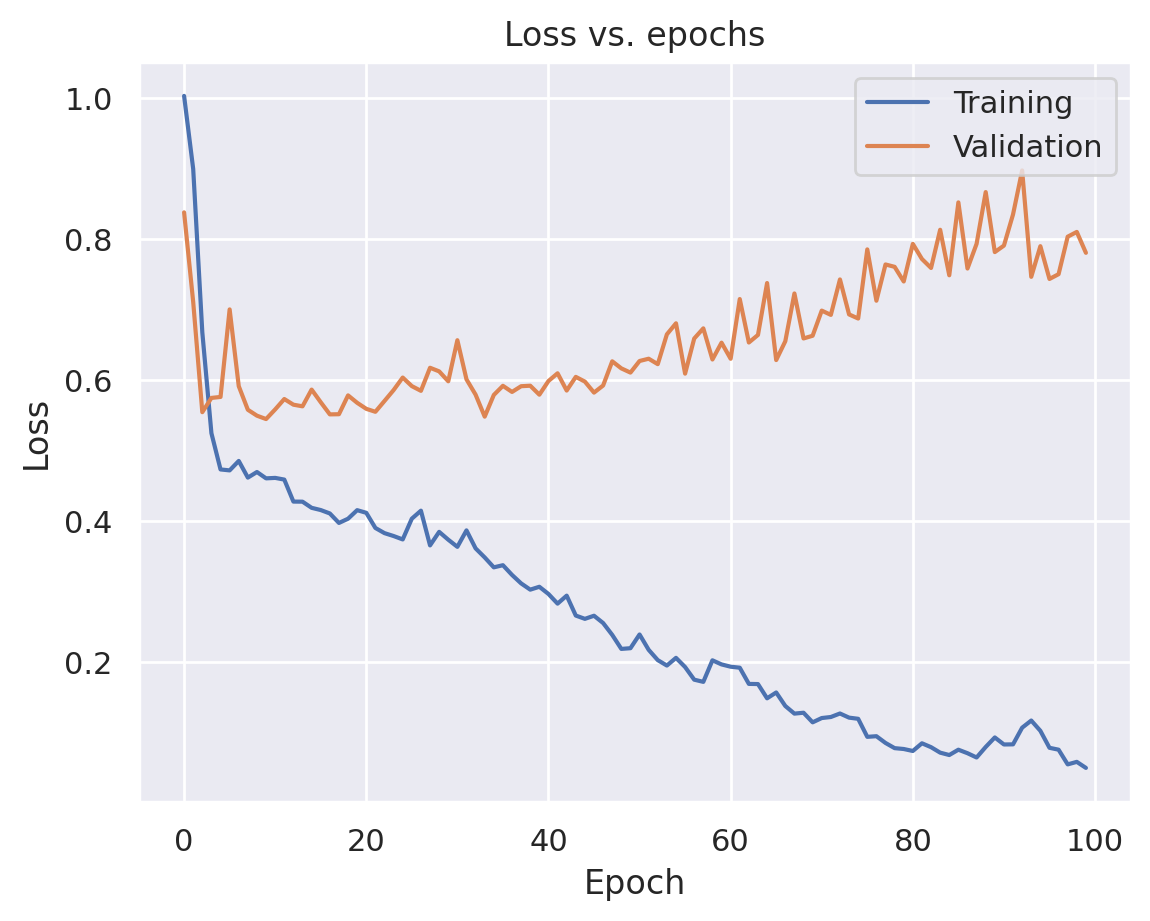

In [13]:
# Plot the training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss vs. epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper right")
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", 
        # kernel_regularizer=tf.keras.regularizers.l2(0.001)
        # kernel_regularizer=tf.keras.regularizers.l1(0.005)
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.005, l2=0.001),
        bias_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[tf.keras.metrics.BinaryAccuracy()])

model.fit(inputs, targets, validation_split=0.25)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

model.fit(inputs, targets, validation_split=0.25) # Training mode, with dropout
model.evaluate(val_inputs, val_targets) # Testing mode, no dropout
model.predict(test_inputs) # Testing mode, no dropout

#### Adding regularisation with weight decay and dropout

In [14]:
def get_regularised_model(wd, rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(wd),
            input_shape=(train_data.shape[1],)),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(wd)),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(wd)),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(wd)),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(wd)),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(wd)),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 128)              

In [16]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

print(model.loss)
print(model.optimizer)

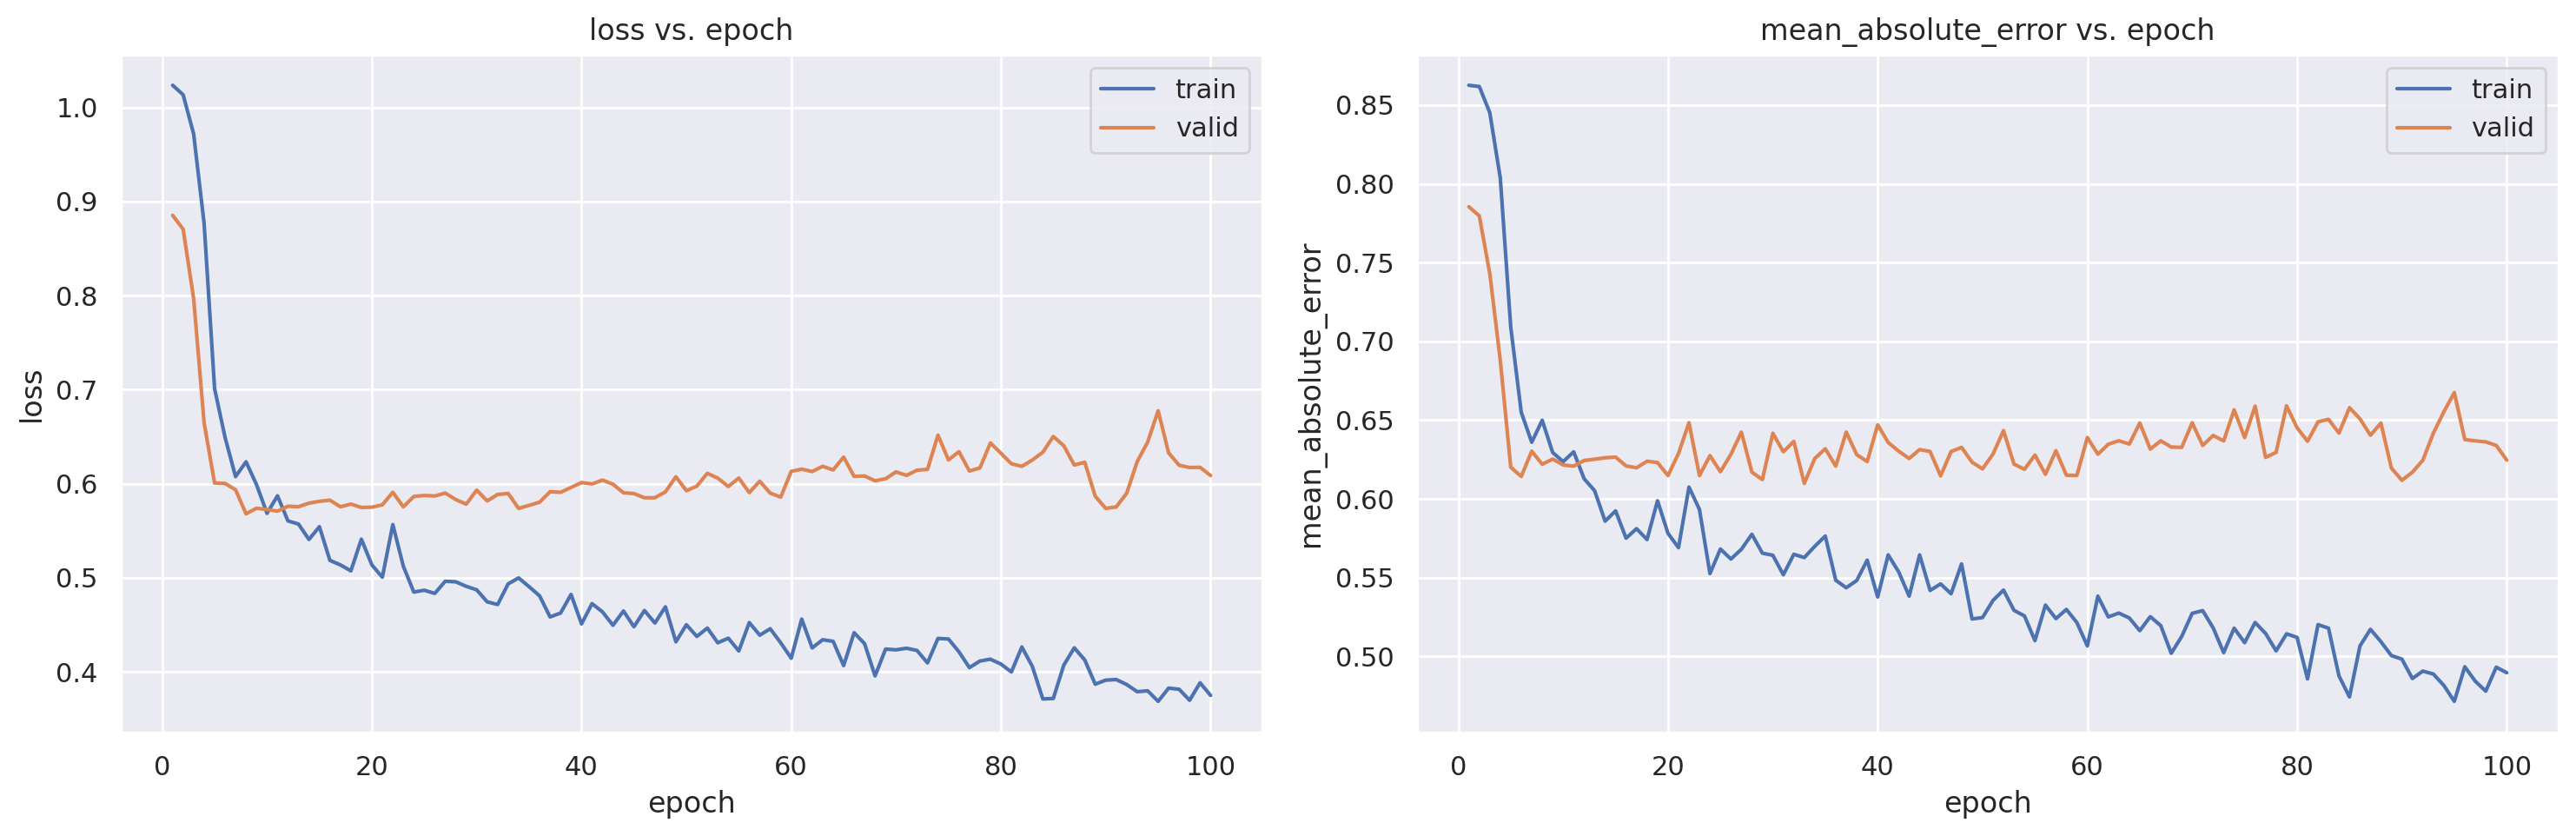

In [17]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100,
    validation_split=0.15, batch_size=64, verbose=0)

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error'])\
    .plot()

In [18]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=0)

[0.4675215482711792, 0.5028077960014343]

#### Plot the learning curves

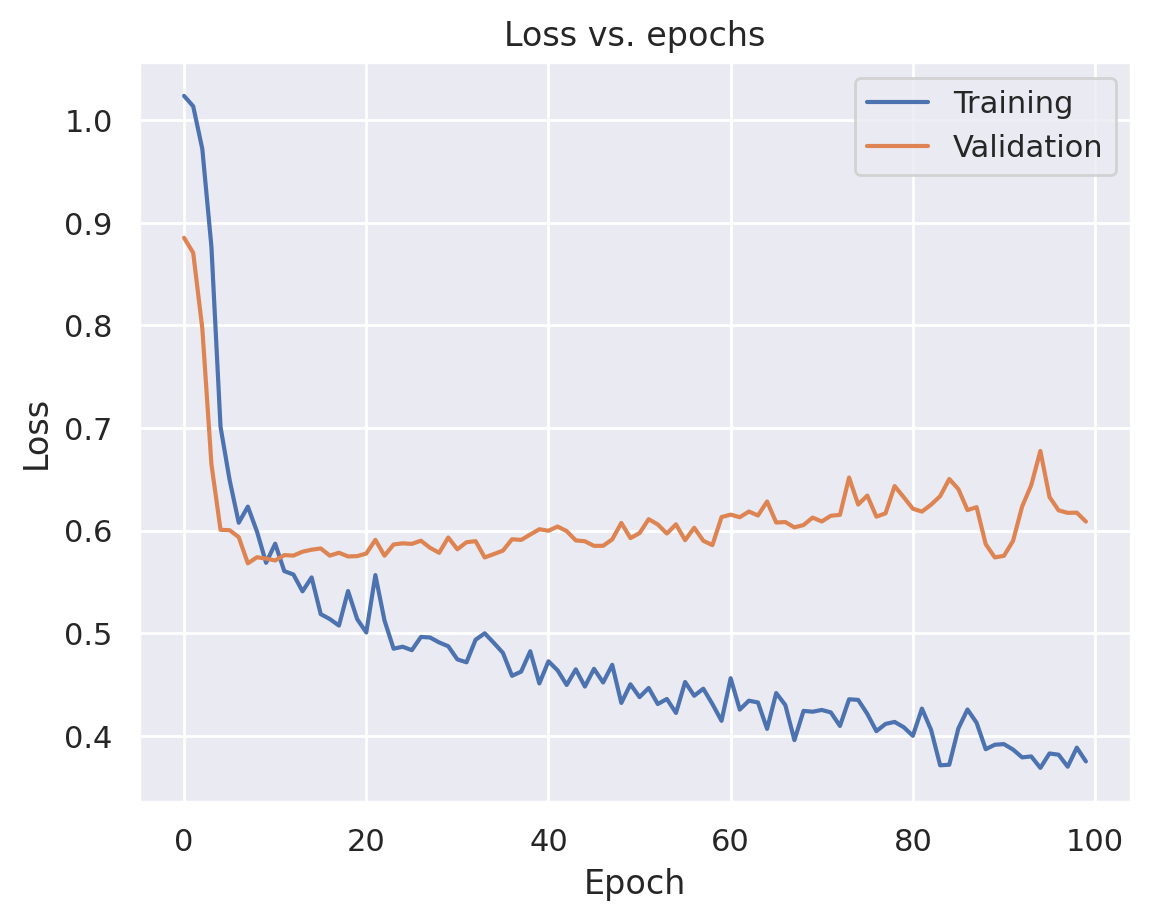

In [19]:
# Plot the training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss vs. epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper right")
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

In [ ]:
class my_callback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        # Do something at the start of training
        
    def on_train_batch_begin(self, batch, logs=None):
        # Do something at the start of every batch iteration
        
    def on_epoch_end(self, epoch, logs=None):
        # Do something at the end of every epoch
        
history = model.fit(X_train, y_train, epochs=5, 
    callbacks=[my_callback()])

#### Example training callback

In [20]:
# Write a custom callback
class TrainingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting training....")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self, logs=None):
        print("Finished training!")

In [21]:
# Re-build the model
model = get_regularised_model(wd=1e-5, rate=0.3)
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               1408      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 128)              

In [22]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

print(model.loss)
print(model.optimizer)

#### Train the model with the callback

Starting training....
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Finished epoch 2
Finished training!


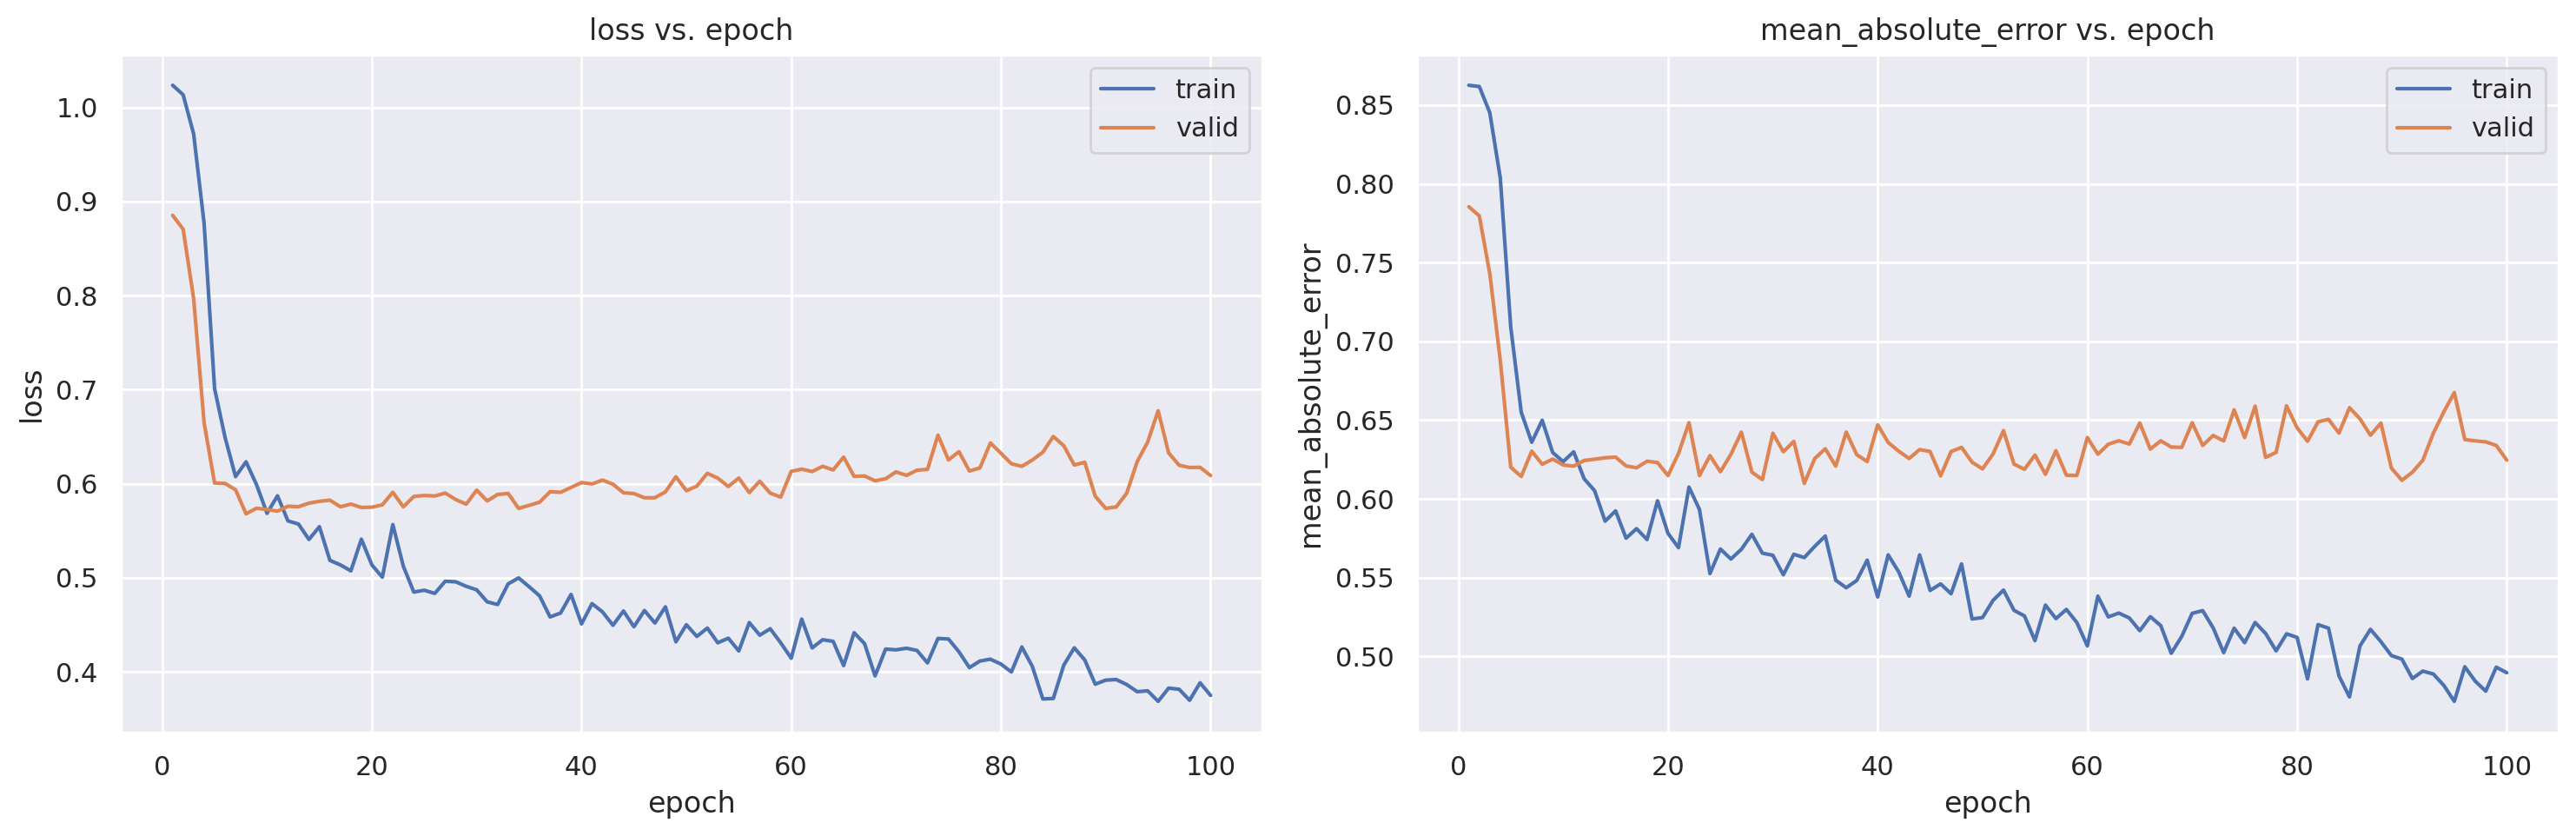

In [23]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, validation_split=0.15, 
    epochs=3, batch_size=128, verbose=0, 
    callbacks=[TrainingCallback()])

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error'])\
    .plot()

In [24]:
# Write a custom callback
class TestingCallback(tf.keras.callbacks.Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting testing....")
        
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
        
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}")
        
    def on_test_end(self, logs=None):
        print("Finished testing!")

In [25]:
# Evaluate the model
model.evaluate(test_data, test_targets, verbose=0,
    callbacks=[TestingCallback()])

Starting testing....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing!


[0.9935458898544312, 0.863059937953949]

In [26]:
# Write a custom callback
class PredictionCallback(tf.keras.callbacks.Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting prediction...")
        
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finished batch {batch}")
        
    def on_predict_end(self, logs=None):
        print("Finished prediction!")

In [27]:
# Make predictions with the model
model.predict(test_data, verbose=0, 
    callbacks=[PredictionCallback()])

Starting prediction...
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished prediction!


array([[ 0.03950521],
       [ 0.02157236],
       [ 0.02733867],
       [ 0.09570064],
       [ 0.02325133],
       [ 0.00444926],
       [ 0.07833271],
       [ 0.05743939],
       [ 0.00190371],
       [ 0.01257562],
       [-0.00866438],
       [ 0.01874474],
       [-0.01487004],
       [ 0.06148753],
       [-0.00025009],
       [ 0.00832536],
       [ 0.06966817],
       [ 0.07845169],
       [ 0.04045451],
       [ 0.0624149 ],
       [ 0.04550091],
       [-0.00759711],
       [-0.01677202],
       [ 0.0489639 ],
       [ 0.01047374],
       [ 0.03244898],
       [ 0.04387822],
       [ 0.04277341],
       [-0.01902581],
       [ 0.01541713],
       [ 0.04164994],
       [-0.00568536],
       [ 0.02195207],
       [ 0.04495732],
       [ 0.06045593],
       [ 0.05487574],
       [ 0.01023125],
       [ 0.01712563],
       [ 0.04391112],
       [-0.01909346],
       [-0.01675658],
       [-0.00270868],
       [ 0.02605078],
       [ 0.04914606],
       [ 0.02524805]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(16, 5, activation='relu', 
        input_shape=(128, 1)),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss'
    monitor='val_accuracy',
    patience=5,
    min_delta=0.01,
    mode='max'
)

model.fit(X_train, y_train, validation_split=0.2, epochs=100,
    callbacks=[early_stopping])

#### Re-train the models with early stopping

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               1408      
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dense_30 (Dense)            (None, 128)               16512     
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dense_32 (Dense)            (None, 128)               16512     
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 dense_34 (Dense)            (None, 1)                

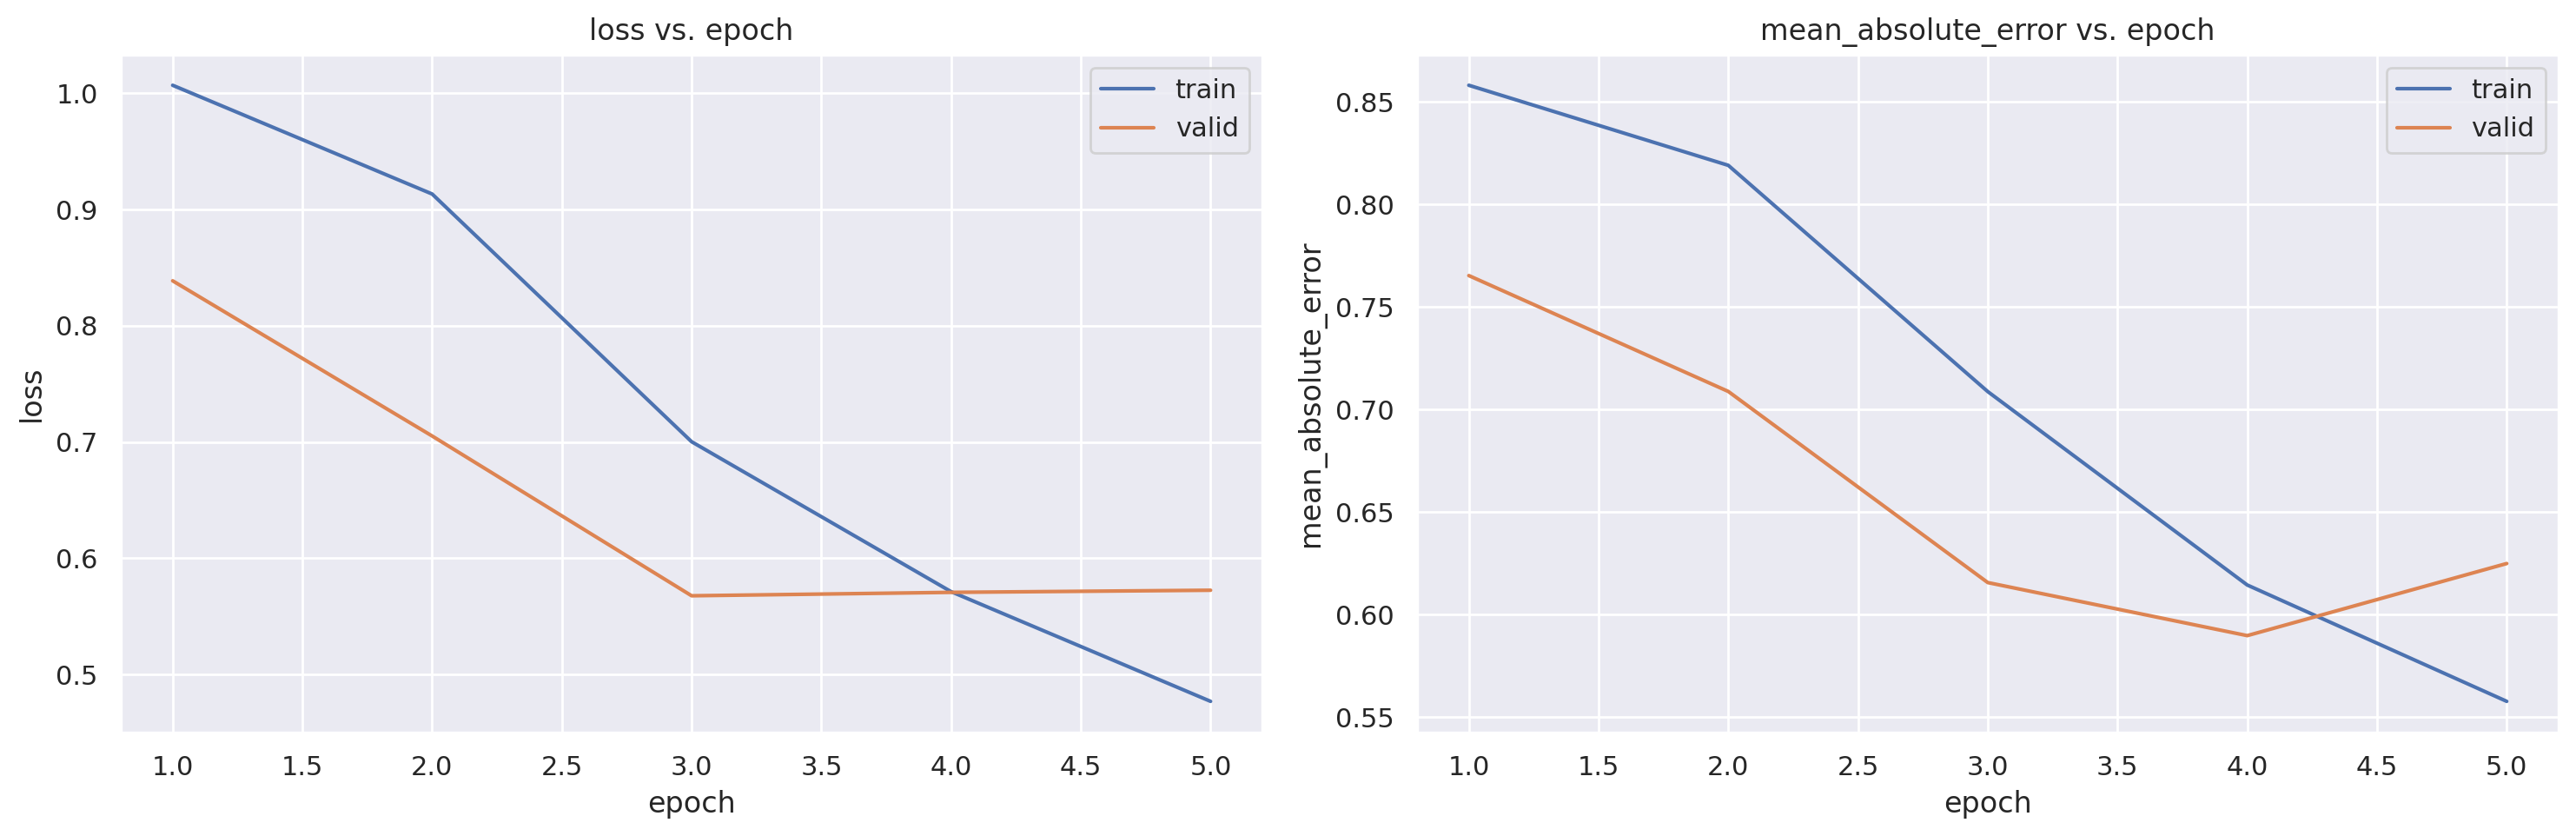

[0.463775634765625, 0.5386271476745605]

In [28]:
# Re-train the unregularized model
unregularised_model = get_model()
print(unregularised_model.summary())

# Compile the model
unregularised_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])
print(unregularised_model.loss)
print(unregularised_model.optimizer)

# Train the model, with some of the data reserved for validation
unreg_history = unregularised_model.fit(train_data, train_targets, 
    validation_split=0.15, batch_size=64, verbose=0, epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])
# Plot training history
PlotHistory(unreg_history, metrics=['loss', 'mean_absolute_error'])\
    .plot()

# Evaluate the model on the test set
unregularised_model.evaluate(test_data, test_targets, verbose=0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               1408      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 128)              

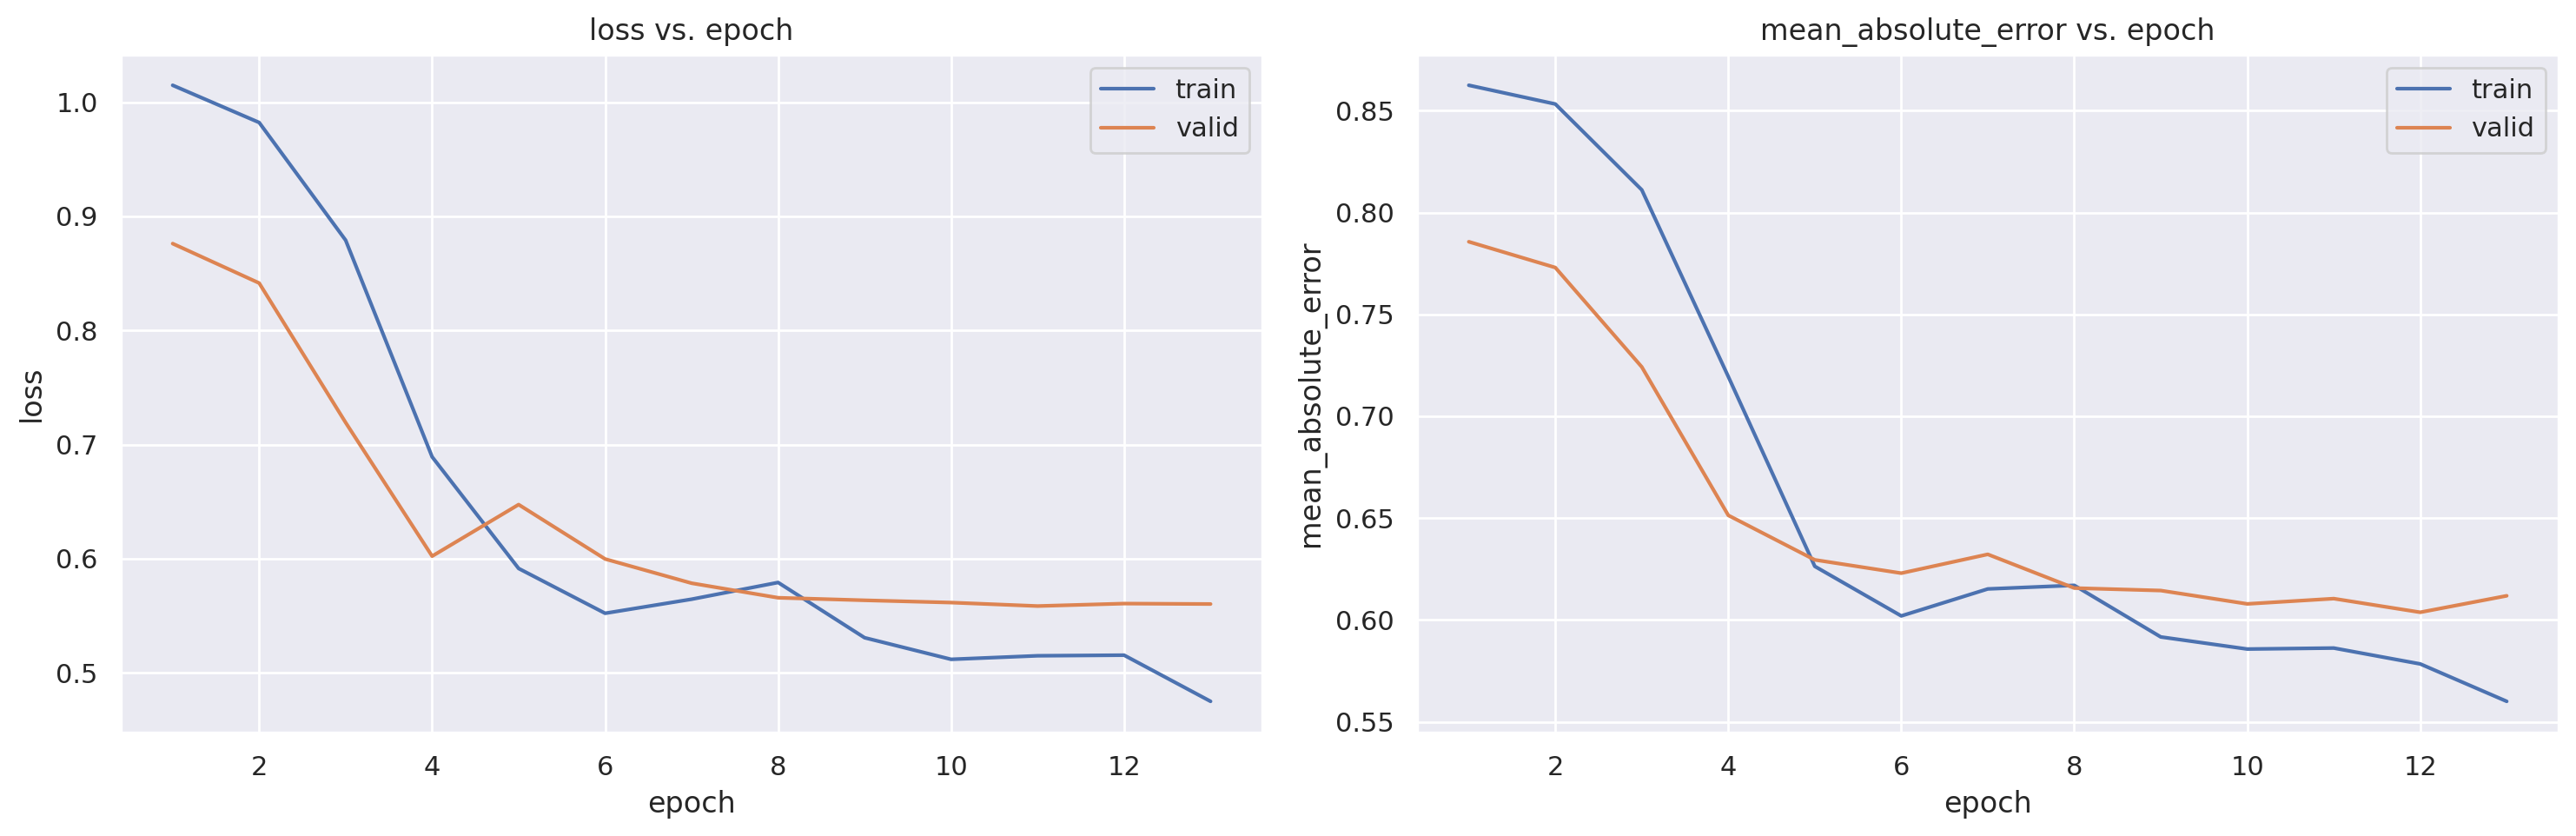

[0.37738803029060364, 0.4868127107620239]

In [29]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8, 0.2)
print(regularised_model.summary())

# Compile the model
regularised_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])
print(regularised_model.loss)
print(regularised_model.optimizer)

# Train the model, with some of the data reserved for validation
reg_history = regularised_model.fit(train_data, train_targets, 
    validation_split=0.15, batch_size=64, verbose=0, epochs=100, 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])
# Plot training history
PlotHistory(reg_history, metrics=['loss', 'mean_absolute_error'])\
    .plot()

# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose=0)

#### Plot the learning curves

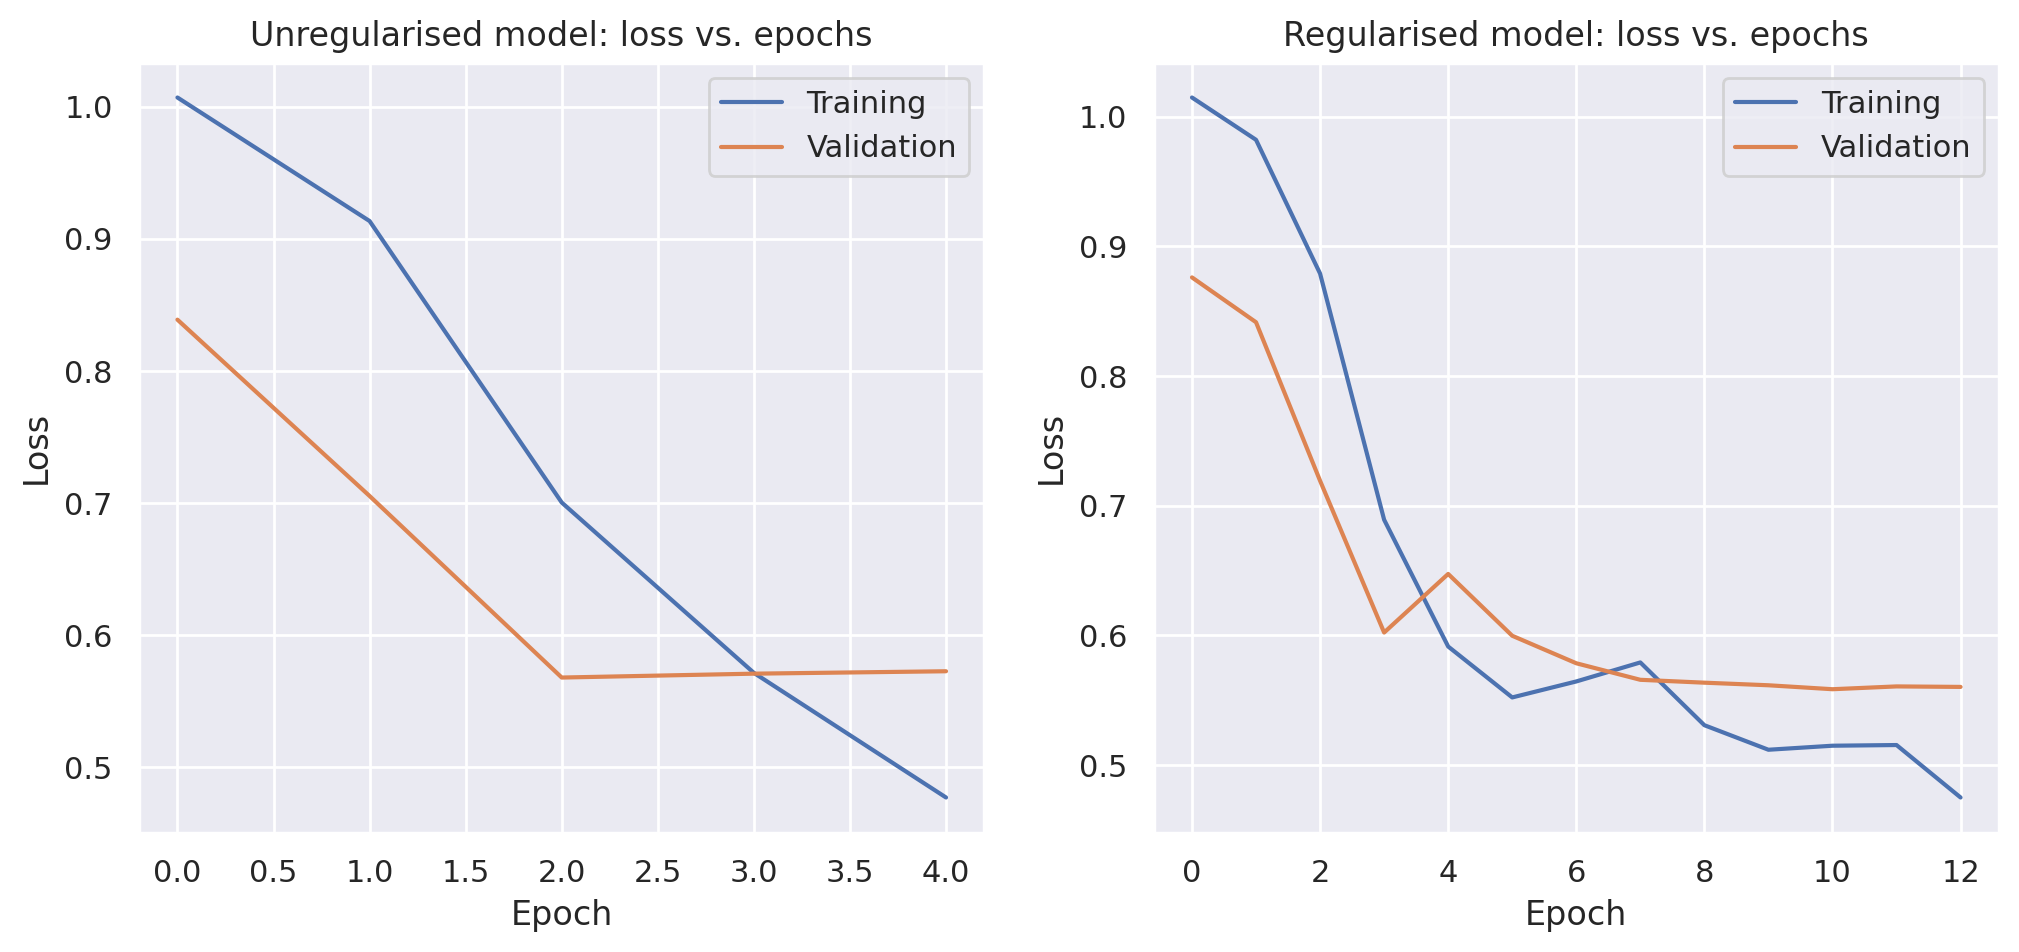

In [30]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()